In [1]:
!pip install -U segmentation_models --quiet
# !pip install tensorflow==2.1.0 --quiet
# !pip install keras ==2.3.1 --quiet

In [2]:
import segmentation_models as sm
# you have to delete the "generic_utils" from the file that makes the segmentatin_models import fail, then restart the runtime

Segmentation Models: using `keras` framework.


In [3]:
import zipfile
zipfile.ZipFile('/content/ACDC.zip', 'r').extractall('/content')

In [4]:
import tensorflow as tf
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical

SIZE_X = 256
SIZE_Y = 256

dataset_folder = f'/content/ACDC/database'
image_files = sorted(os.listdir(f'{dataset_folder}/train'))
mask_files = sorted(os.listdir(f'{dataset_folder}/trainannot'))
train_images = []
train_masks = []

for img_path, mask_path in zip(image_files, mask_files):
    img = cv2.imread(f'{dataset_folder}/train/{img_path}', 1) #change this to 0 to read it in grayscale
    # img = cv2.resize(img, (SIZE_Y, SIZE_X)) #the images were already the appropriate size
    img = img.astype(float) / 255.0
    train_images.append(img)

    mask = cv2.imread(f'{dataset_folder}/trainannot/{mask_path}', 0)
    # mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) #the masks were already the appropriate size
    mask = mask.astype(float)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

X = train_images
# X = np.expand_dims(X, axis=3) #needed, if we read images as grayscale
Y = train_masks
Y = np.expand_dims(Y, axis=3)


In [5]:
print("Total images in the  dataset: \t", len(train_images))
print("Image data shape is: \t\t", train_images.shape)
# print("Expanded mask data shape is: \t", X.shape)
print("Mask data shape is: \t\t", train_masks.shape)
print("Expanded mask data shape is: \t", Y.shape)
print("Max pixel value in image is: \t", train_images.max())
print("Labels in the mask are : \t", np.unique(train_masks))

Total images in the  dataset: 	 600
Image data shape is: 		 (600, 256, 256, 3)
Mask data shape is: 		 (600, 256, 256)
Expanded mask data shape is: 	 (600, 256, 256, 1)
Max pixel value in image is: 	 1.0
Labels in the mask are : 	 [0. 1. 2. 3.]


random number generaterd:  392


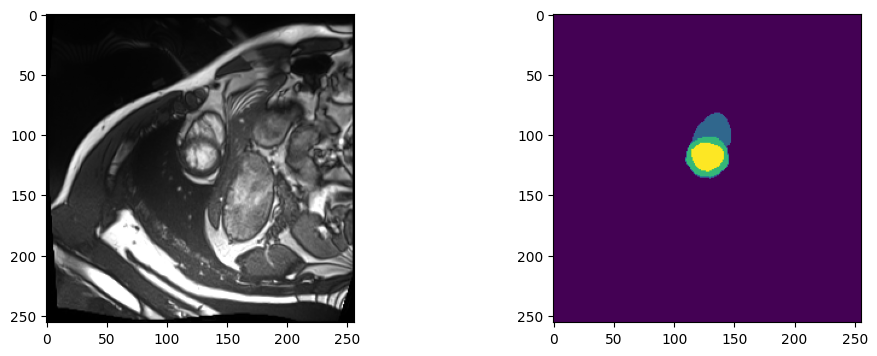

In [6]:
import random

i = random.randint(0, 600)
print("random number generaterd: ", i)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(X[i])
plt.subplot(122)
plt.imshow(Y[i])

In [7]:

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras

BACKBONE = 'resnet34'
BATCH_SIZE = 8
EPOCHS = 30
LR = 0.0001
n_classes = 4

preprocess_input = sm.get_preprocessing(BACKBONE)


x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

y_train_cat = to_categorical(y_train, num_classes=n_classes).reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
y_val_cat = to_categorical(y_val, num_classes=n_classes).reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

print("The inputs are:")
print("\tx_train: \t", x_train.shape)
print("\tx_val: \t\t", x_val.shape)
print("Class values in the dataset: ", np.unique(y_train))
print("\ty_train: \t", y_train.shape)
print("\ty_val: \t\t", y_val.shape)
print("Converting to vategorical data:")
print("\ty_train_cat: \t", y_train_cat.shape)
print("\ty_val_cat: \t", y_val_cat.shape)
# print("Class values in the dataset: ", np.unique(y_train_cat))
# print("Class values in the dataset: ", np.unique(y_val_cat))

activation = 'softmax'
optim = keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
loss = total_loss

# loss = sm.losses.DiceLoss(class_indexes=range(1, n_classes + 1))
# loss = sm.losses.JaccardLoss()
# metrics = ['accuracy']

model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation=activation, classes=n_classes)
# model = sm.Unet(BACKBONE, input_shape=(256, 256, 3), encoder_weights=None, activation=activation, classes=n_classes)

model.compile(optimizer=optim, loss=loss, metrics=metrics)
# model.compile(optimizer='Adam', loss=loss, metrics=metrics)


print(model.summary())


The inputs are:
	x_train: 	 (480, 256, 256, 3)
	x_val: 		 (120, 256, 256, 3)
Class values in the dataset:  [0. 1. 2. 3.]
	y_train: 	 (480, 256, 256, 1)
	y_val: 		 (120, 256, 256, 1)
Converting to vategorical data:
	y_train_cat: 	 (480, 256, 256, 4)
	y_val_cat: 	 (120, 256, 256, 4)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_pa

In [8]:
# it takes about 4 mins to train
history=model.fit(x_train, y_train_cat,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  verbose=1,
                  validation_data=(x_val, y_val_cat))

Epoch 1/30
60/60 [==============================] - 52s 214ms/step - loss: 0.9754 - iou_score: 0.2191 - f1-score: 0.3146 - val_loss: 0.9990 - val_iou_score: 1.2490e-09 - val_f1-score: 1.2490e-09
Epoch 2/30
60/60 [==============================] - 11s 178ms/step - loss: 0.9306 - iou_score: 0.5431 - f1-score: 0.6461 - val_loss: 0.9639 - val_iou_score: 0.1905 - val_f1-score: 0.2162
Epoch 3/30
60/60 [==============================] - 11s 178ms/step - loss: 0.9013 - iou_score: 0.6878 - f1-score: 0.7908 - val_loss: 0.9521 - val_iou_score: 0.2387 - val_f1-score: 0.2442
Epoch 4/30
60/60 [==============================] - 11s 188ms/step - loss: 0.8709 - iou_score: 0.7587 - f1-score: 0.8498 - val_loss: 0.9476 - val_iou_score: 0.2405 - val_f1-score: 0.2451
Epoch 5/30
60/60 [==============================] - 12s 195ms/step - loss: 0.8399 - iou_score: 0.8013 - f1-score: 0.8816 - val_loss: 0.9480 - val_iou_score: 0.2405 - val_f1-score: 0.2451
Epoch 6/30
60/60 [==============================] - 11s 1

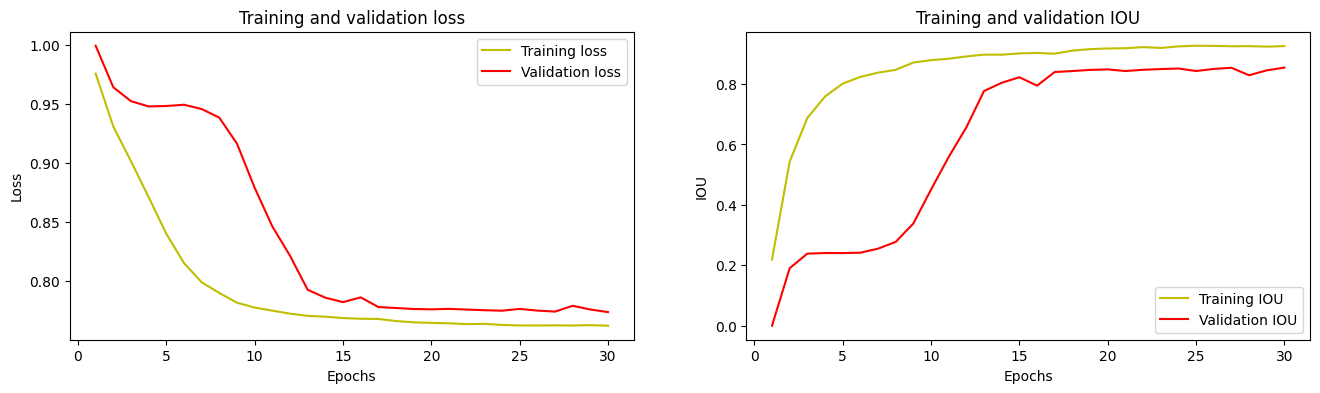

In [9]:

loss, val_loss, acc, val_acc = history.history['loss'], history.history['val_loss'], history.history['iou_score'], history.history['val_iou_score']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(epochs, loss, 'y', label='Training loss')
axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
axes[1].plot(epochs, acc, 'y', label='Training IOU')
axes[1].plot(epochs, val_acc, 'r', label='Validation IOU')

[ax.set_xlabel('Epochs') for ax in axes] and [ax.legend() for ax in axes]

axes[0].set_title('Training and validation loss')
axes[0].set_ylabel('Loss')
axes[1].set_title('Training and validation IOU')
axes[1].set_ylabel('IOU')

plt.savefig('/content/base_model_loss_plot.png')
plt.show()


In [10]:
model.save('/content/base_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


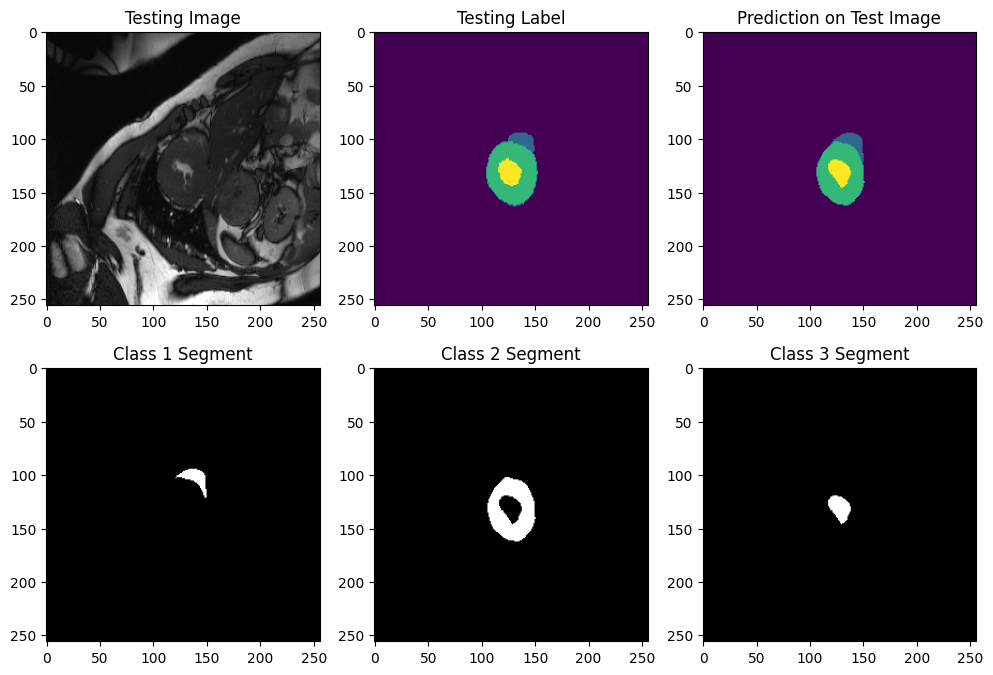

In [11]:
import random
from keras.models import load_model

model = load_model('/content/base_model.h5', compile=False)
img_num = random.randint(0, len(x_val) - 1)

test_img = x_val[img_num]
test_img_gt = y_val[img_num]

test_img_input = np.expand_dims(preprocess_input(test_img), 0)
test_img_pred = np.argmax(model.predict(test_img_input), axis=3)[0,:,:]


plt.figure(figsize=(12, 8))

# First row: Original image, Ground truth label, and Full prediction
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img_gt)

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(test_img_pred)

# Second row: Displaying the segments of the three classes separately
class_segments = [np.where(test_img_pred == i + 1, i + 1, 0) for i in range(3)]
titles = ['Class 1 Segment', 'Class 2 Segment', 'Class 3 Segment']

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.title(titles[i])
    plt.imshow(class_segments[i], cmap='gray')

plt.savefig('/content/base_model_prediction_plot.png')
plt.show()


In [12]:

# from keras.metrics import MeanIoU
# import os
# import cv2
# import numpy as np

# dataset_folder = '/content/ACDC/database'
# image_files = sorted(os.listdir(f'{dataset_folder}/test'))
# mask_files = sorted(os.listdir(f'{dataset_folder}/testannot'))

# test_images = []
# test_masks = []

# for img_path, mask_path in zip(image_files, mask_files):
#     img = cv2.imread(f'{dataset_folder}/test/{img_path}', 1)
#     img = img.astype(float) / 255.0
#     test_images.append(img)

#     mask = cv2.imread(f'{dataset_folder}/testannot/{mask_path}', 0)
#     mask = mask.astype(float)
#     test_masks.append(mask)

# x_test = np.array(test_images)
# y_test = np.expand_dims(np.array(test_masks), axis=3)

# n_classes = 4
# IOU_keras = MeanIoU(num_classes=n_classes)

# mean_iou = 0.0
# for i in range(len(x_test)):
#     test_img = x_test[i]
#     test_img_gt = y_test[i]

#     test_img_input = np.expand_dims(test_img, 0)
#     test_img_pred = np.argmax(model.predict(test_img_input), axis=3)[0,:,:]

#     IOU_keras.update_state(test_img_gt[:,:,0], test_img_pred)
#     mean_iou += IOU_keras.result().numpy()

# mean_iou /= len(x_test)
# print("Mean IoU =", mean_iou)
